In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
import io
import os
import sys
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import albumentations as alb
import torch.multiprocessing as mp
from albumentations.pytorch import ToTensorV2
from albumentations.augmentations.transforms import Cutout
from PIL import Image

import warnings
warnings.filterwarnings('ignore')


In [66]:
sys.path.append(os.path.abspath("/home/bk_anupam/code/ML/ML_UTILS/"))

In [67]:
import cv_split_utils

In [68]:
class ImgStats:
    IMAGENET_MEAN = [0.485, 0.456, 0.406]
    IMAGENET_STD = [0.229, 0.224, 0.225]    

class Config:
    IMG_MEAN = ImgStats.IMAGENET_MEAN
    IMG_STD = ImgStats.IMAGENET_STD
    NUM_WORKERS = mp.cpu_count()
    INPUT_IMAGE_SIZE = (128,128)
    TARGET_COL_NAME = "target"
    RANDOM_SEED = 42
    NUM_FOLDS = 5
    BATCH_SIZE = 4

['ISIC_0015670', 'ISIC_0015845', 'ISIC_0015864', 'ISIC_0015902', 'ISIC_0024200', 'ISIC_0035502', 'ISIC_0051648', 'ISIC_0051665', 'ISIC_0051710', 'ISIC_0051758']
<HDF5 dataset "ISIC_0015670": shape (), type "|S3325">
b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x08\x06\x06\x07\x06\x05\x08\x07\x07\x07\t\t\x08\n\x0c\x14\r\x0c\x0b\x0b\x0c\x19\x12\x13\x0f\x14\x1d\x1a\x1f\x1e\x1d\x1a\x1c\x1c $.\' ",#\x1c\x1c(7),01444\x1f\'9=82<.342\xff\xdb\x00C\x01\t\t\t\x0c\x0b\x0c\x18\r\r\x182!\x1c!22222222222222222222222222222222222222222222222222\xff\xc0\x00\x11\x08\x00\x8b\x00\x8b\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1f\x00\x00\x01\x05\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\t\n\x0b\xff\xc4\x00\xb5\x10\x00\x02\x01\x03\x03\x02\x04\x03\x05\x05\x04\x04\x00\x00\x01}\x01\x02\x03\x00\x04\x11\x05\x12!1A\x06\x13Qa\x07"q\x142\x81\x91\xa1\x08#B\xb1\xc1\x15R\xd1\xf0$3br\x82\t\n\x16\x17\x18\x19\x1a%&\'()*456789:C

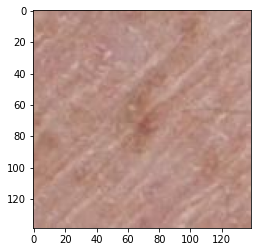

In [40]:
# Open the HDF5 file
with h5py.File('./data/train-image.hdf5', "r") as f:
    # List all the keys (datasets) in the file
    #print(f.keys())
    print(list(f.keys())[:10])
    keys = list(f.keys())
    dataset = f[keys[0]]
    # Print the dataset    
    print(dataset)
    # Read the data from the dataset
    image_byte_data = dataset[()]    
    # Print the data
    print(image_byte_data)
    image = Image.open(io.BytesIO(image_byte_data))
    print(f"image.size = {image.size}")
    plt.imshow(image)

sample_image.size = (139, 139)


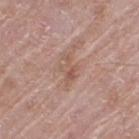

In [42]:
sample_image = Image.open('./data/train-image/image/ISIC_0015670.jpg')
print(f"sample_image.size = {sample_image.size}")
sample_image.show()

In [45]:
sample_image_arr = np.array(image)
sample_image_arr.shape

(139, 139, 3)

In [4]:
df_train_metadata = pd.read_csv("./data/train-metadata.csv")
df_train_metadata.head()


,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,lesion_id,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence
0,ISIC_0015670,0,IP_1235828,60.0,male,lower extremity,3.04,TBP tile: close-up,3D: white,20.244422,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,97.517282
1,ISIC_0015845,0,IP_8170065,60.0,male,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,...,IL_6727506,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,3.141455
2,ISIC_0015864,0,IP_6724798,60.0,male,posterior torso,3.40,TBP tile: close-up,3D: XP,22.575830,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.804040
3,ISIC_0015902,0,IP_4111386,65.0,male,anterior torso,3.22,TBP tile: close-up,3D: XP,14.242329,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.989998
4,ISIC_0024200,0,IP_8313778,55.0,male,anterior torso,2.73,TBP tile: close-up,3D: white,24.725520,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,70.442510


In [5]:
# There are 401059 total samples
len(df_train_metadata)

401059

In [43]:
# train data contains only 393 positive samples 
df_train_metadata['target'].value_counts()

target
0    400666
1       393
Name: count, dtype: int64

In [49]:
# There are 1042 unique patients
df_train_metadata["patient_id"].nunique()

1042

In [50]:
df_train_metadata.groupby(["target"])["patient_id"].nunique()

target
0    1041
1     259
Name: patient_id, dtype: int64

In [63]:
# find patient_id where target is both 0 and 1
# This groups the DataFrame by target and applies the set function to the patient_id column in each group, 
# resulting in a Series where each entry is a set of unique patient_ids for each target value.
grouped_patient_id = df_train_metadata.groupby(["target"])["patient_id"].apply(set)
patient_id_0 = grouped_patient_id[0]
print(f"Number of patient_id where target is 0 = {len(patient_id_0)}")
patient_id_1 = grouped_patient_id[1]
print(f"Number of patient_id where target is 1 = {len(patient_id_1)}")
patient_id_0_and_1 = patient_id_0.intersection(patient_id_1)
print(f"Number of patient_id where target is both 0 and 1 = {len(patient_id_0_and_1)}")
# patient_id where target is 1 but not 0
patient_id_1_not_0 = patient_id_1.difference(patient_id_0)
print(f"Number of patient_id where target is 1 but not 0 = {len(patient_id_1_not_0)}, patient_id = {patient_id_1_not_0}")


Number of patient_id where target is 0 = 1041
Number of patient_id where target is 1 = 259
Number of patient_id where target is both 0 and 1 = 258
Number of patient_id where target is 1 but not 0 = 1, patien_id = {'IP_7696347'}


In [ ]:
# We need to ensure the same group (patient_id) doesn't appear both in train and validation set. Also we need to ensure
# class distribution is maintained
df_train_metadata = cv_split_utils.strat_group_kfold_dataframe(
                        df=df_train_metadata, 
                        target_col_name=Config.TARGET_COL_NAME, 
                        group_col_name="patient_id",
                        random_state=Config.RANDOM_SEED, 
                        num_folds=Config.NUM_FOLDS
                    )

In [ ]:
class ISICHDF5Dataset(Dataset):
    def __init__(self, hdf5_file_path, df, target_col, transform=None, target_transform=None):
        self.df = df
        self.hdf5_file_path = hdf5_file_path        
        self.target_col = target_col
        self.transform = transform
        self.target_transform = target_transform
        with h5py.File(hdf5_file_path, "r") as f:
            self.keys = list(f.keys())
    
    def __len__(self):
        return len(self.keys)
    
    def __getitem__(self, idx):
        # idx is the index of the image in the hdf5 file which is the same as index in the image metadata dataframe.         
        img_label = self.df.loc[idx, self.target_col]
        img_id = self.df.loc[idx, "isic_id"]
        patient_id = self.df.loc[idx, "patient_id"]
        with h5py.File(self.hdf5_file_path, "r") as f:
            key = self.keys[idx]
            dataset = f[key]
            # the dataset is scalar i.e. contains only a single element which is image byte data in string format
            # To retrieve the single element from dataset we need to use the following code
            image_byte_data = dataset[()]
            img = Image.open(io.BytesIO(image_byte_data))
            img_arr = np.array(img)
            if self.transform:
                augmented = self.transform(image=img_arr)
                img_tfmd = augmented["image"]
            if self.target_transform is not None:
                img_label = self.target_transform(img_label)
            return img_id, patient_id, img_tfmd, img_label

In [69]:
train_transform = alb.Compose([
        alb.RandomResizedCrop(Config.INPUT_IMAGE_SIZE[0], Config.INPUT_IMAGE_SIZE[1]),        
        alb.HorizontalFlip(p=0.5),
        alb.VerticalFlip(p=0.5),
        alb.RandomRotate90(p=0.5),
        alb.Flip(p=0.5),
        alb.Downscale(p=0.25),
        alb.ShiftScaleRotate(shift_limit=0.1, 
                           scale_limit=0.15, 
                           rotate_limit=60, 
                           p=0.5),
        alb.HueSaturationValue(
                hue_shift_limit=0.2, 
                sat_shift_limit=0.2, 
                val_shift_limit=0.2, 
                p=0.5
            ),
        alb.RandomBrightnessContrast(
                brightness_limit=(-0.1,0.1), 
                contrast_limit=(-0.1, 0.1), 
                p=0.5
            ),
        alb.Normalize(mean=Config.IMG_MEAN, std=Config.IMG_STD),
        ToTensorV2()
])
val_transform = alb.Compose([
        alb.CenterCrop(Config.INPUT_IMAGE_SIZE[0], Config.INPUT_IMAGE_SIZE[1]),
        alb.Normalize(mean=Config.IMG_MEAN, std=Config.IMG_STD),
        ToTensorV2()
])

In [ ]:
def get_fold_dls(fold, df_img_metadata, hdf5_file_path):
    df_train = df_img_metadata[df_img_metadata["kfold"] != fold].reset_index(drop=True)
    df_val = df_img_metadata[df_img_metadata["kfold"] == fold].reset_index(drop=True)
    print(f"Fold {fold}: {df_train.shape[0]} train - {df_val.shape[0]} val")
    ds_train = ISICHDF5Dataset(
        hdf5_file_path=hdf5_file_path, 
        df=df_train,
        target_col=Config.TARGET_COL_NAME,        
        transform=train_transform,
        target_transform=torch.as_tensor
    )
    ds_val = ISICHDF5Dataset(
        hdf5_file_path=hdf5_file_path, 
        df=df_val,
        target_col=Config.TARGET_COL_NAME,        
        transform=val_transform,
        target_transform=torch.as_tensor
    )
    dl_train = DataLoader(ds_train, batch_size=Config.BATCH_SIZE, shuffle=True, num_workers=Config.NUM_WORKERS)    
    dl_val = DataLoader(ds_val, batch_size=Config.BATCH_SIZE, num_workers=Config.NUM_WORKERS)
    return dl_train, dl_val, ds_train, ds_val